
FOLD 1/5
--------------------
Epoch 1: Train Loss 2.6574, Train Acc 0.3815, Val Loss 0.7380, Val Acc 0.4847
Epoch 2: Train Loss 0.3683, Train Acc 0.6879, Val Loss 2.6739, Val Acc 0.4466
Epoch 3: Train Loss 0.2475, Train Acc 0.8062, Val Loss 0.5013, Val Acc 0.6692
Epoch 4: Train Loss 0.1941, Train Acc 0.8521, Val Loss 0.1529, Val Acc 0.8397
Epoch 5: Train Loss 0.0945, Train Acc 0.9128, Val Loss 0.3362, Val Acc 0.8919
Epoch 6: Train Loss 0.0706, Train Acc 0.9319, Val Loss 0.0976, Val Acc 0.9580
Epoch 7: Train Loss 0.1142, Train Acc 0.9109, Val Loss 0.1338, Val Acc 0.9097
Epoch 8: Train Loss 0.0875, Train Acc 0.9249, Val Loss 0.1673, Val Acc 0.9351
Epoch 9: Train Loss 0.0577, Train Acc 0.9497, Val Loss 0.0295, Val Acc 0.9733
Epoch 10: Train Loss 0.0624, Train Acc 0.9513, Val Loss 0.0346, Val Acc 0.9707
Epoch 11: Train Loss 0.1854, Train Acc 0.8944, Val Loss 4.5202, Val Acc 0.3473
Epoch 12: Train Loss 0.2367, Train Acc 0.8603, Val Loss 0.1289, Val Acc 0.8944
Early stopping at epoch 12
Fol

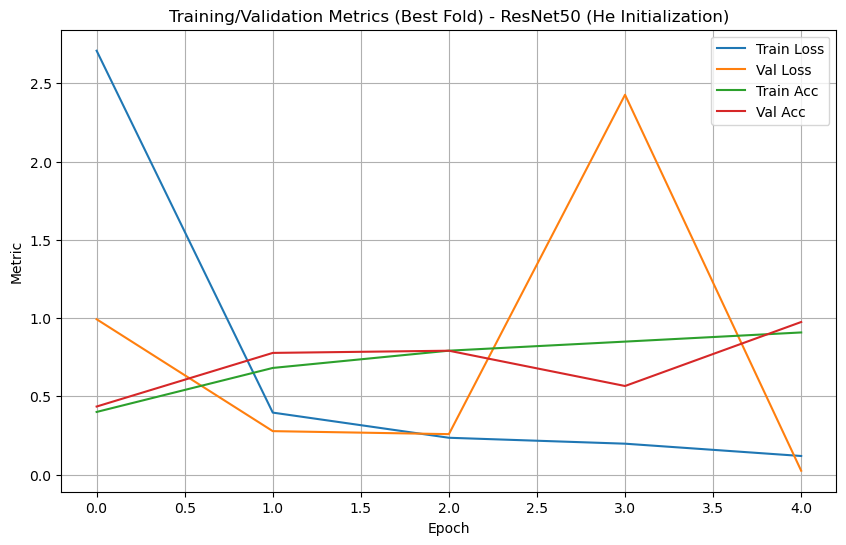

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy
import matplotlib.pyplot as plt

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(sub_path, fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)
        return img, label


# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MultiLabelDataset(
    "", #Include data path 
    transform=transform
)


# -------------------- He Initialization Function --------------------
def init_weights(m):
    """Apply Kaiming (He) initialization to Conv and Linear layers."""
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)


# -------------------- Model Loader --------------------
def get_model():
    # Load ResNet50 architecture, no pretrained weights
    model = models.resnet50(weights=None)

    # Replace fully connected layer for 3 output nodes (multi-label)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 3)

    # Apply He initialization to all layers
    model.apply(init_weights)

    return model


# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None
best_fold_history = None

# Early stopping parameters
patience = 3
min_delta = 1e-4

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold+1}/{k_folds}")
    print("-" * 20)

    train_sub = Subset(dataset, train_ids)
    val_sub = Subset(dataset, val_ids)

    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_sub, batch_size=16)

    model = get_model().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    best_val_acc = 0.0
    best_fold_wts = None
    epochs_no_improve = 0
    num_epochs = 30

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        # ---- Training ----
        model.train()
        running_loss = 0.0
        y_true_train, y_pred_train = [], []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = (torch.sigmoid(out) > 0.5).int()
            y_true_train.extend(y.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(y_true_train, y_pred_train)

        # ---- Validation ----
        model.eval()
        y_true, y_pred = [], []
        val_loss_total = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss_total += loss.item()
                preds = (torch.sigmoid(out) > 0.5).int()
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss = val_loss_total / len(val_loader)
        val_acc = accuracy_score(y_true, y_pred)

        print(f"Epoch {epoch+1}: "
              f"Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, "
              f"Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # ---- Early stopping ----
        if val_acc - best_val_acc > min_delta:
            best_val_acc = val_acc
            best_fold_wts = deepcopy(model.state_dict())
            best_fold_history = deepcopy(history)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    results.append(best_val_acc)
    print(f"Fold {fold+1} Best Val Accuracy: {best_val_acc:.4f}")

    if best_val_acc > best_acc:
        best_acc = best_val_acc
        best_model_wts = deepcopy(best_fold_wts)

print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f}")

# -------------------- Save Best Model --------------------
save_path = "" #Include save path 
torch.save(best_model_wts, save_path)

# -------------------- Plot final Fold History --------------------
plt.figure(figsize=(10, 6))
plt.plot(best_fold_history["train_loss"], label="Train Loss")
plt.plot(best_fold_history["val_loss"], label="Val Loss")
plt.plot(best_fold_history["train_acc"], label="Train Acc")
plt.plot(best_fold_history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Training/Validation Metrics (Best Fold) - ResNet50 (He Initialization)")
plt.legend()
plt.grid(True)
plt.show()


fan_in


FOLD 1/5
--------------------
Epoch 1: Train Loss 0.5336, Train Acc 0.4788, Val Loss 0.6046, Val Acc 0.5038
Epoch 2: Train Loss 0.2009, Train Acc 0.7986, Val Loss 0.1603, Val Acc 0.8295
Epoch 3: Train Loss 0.1247, Train Acc 0.8832, Val Loss 0.1827, Val Acc 0.8079
Epoch 4: Train Loss 0.0949, Train Acc 0.9074, Val Loss 1.1335, Val Acc 0.6819
Epoch 5: Train Loss 0.0612, Train Acc 0.9440, Val Loss 0.0583, Val Acc 0.9580
Epoch 6: Train Loss 0.0617, Train Acc 0.9411, Val Loss 0.5113, Val Acc 0.7735
Epoch 7: Train Loss 0.0321, Train Acc 0.9672, Val Loss 0.0123, Val Acc 0.9898
Epoch 8: Train Loss 0.0440, Train Acc 0.9574, Val Loss 0.0128, Val Acc 0.9860
Epoch 9: Train Loss 0.0258, Train Acc 0.9784, Val Loss 0.1656, Val Acc 0.8842
Epoch 10: Train Loss 0.0366, Train Acc 0.9675, Val Loss 0.0962, Val Acc 0.9148
Early stopping at epoch 10
Fold 1 Best Val Accuracy: 0.9898

FOLD 2/5
--------------------
Epoch 1: Train Loss 0.5359, Train Acc 0.4687, Val Loss 0.2735, Val Acc 0.7036
Epoch 2: Train Loss

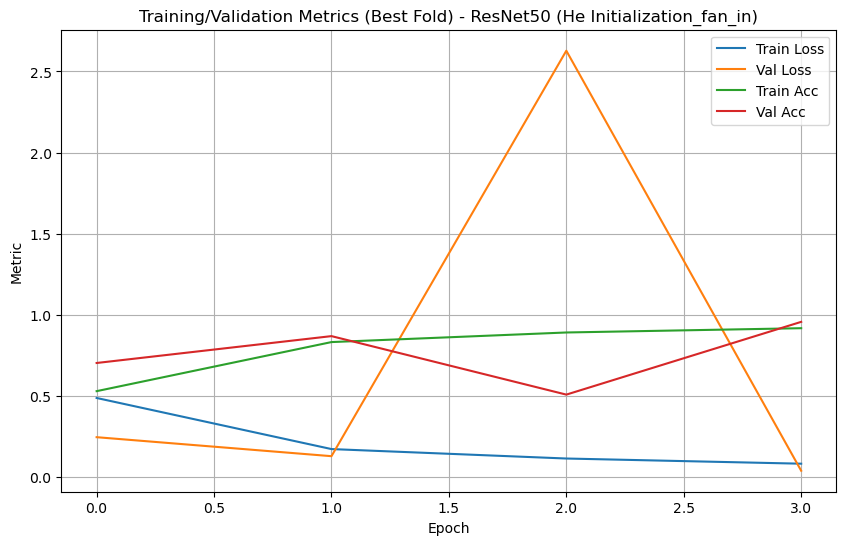

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
from copy import deepcopy
import matplotlib.pyplot as plt

# -------------------- Dataset --------------------
class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        for subfolder in os.listdir(root_dir):
            sub_path = os.path.join(root_dir, subfolder)
            if not os.path.isdir(sub_path):
                continue
            label_vector = [int(x) for x in subfolder.split('_')]
            for fname in os.listdir(sub_path):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(sub_path, fname))
                    self.labels.append(label_vector)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)

        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)

        # expand grayscale → 3 channels
        img = img.repeat(3, 1, 1)
        return img, label


# -------------------- Transforms --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MultiLabelDataset(
    "", #Include data path 
    transform=transform
)


# -------------------- He Initialization Function --------------------
def init_weights(m):
    """Apply Kaiming (He) initialization to Conv and Linear layers."""
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)


# -------------------- Model Loader --------------------
def get_model():
    # Load ResNet50 architecture, no pretrained weights
    model = models.resnet50(weights=None)

    # Replace fully connected layer for 3 output nodes (multi-label)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 3)

    # Apply He initialization to all layers
    model.apply(init_weights)

    return model


# -------------------- KFold Cross-validation --------------------
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_acc = 0.0
best_model_wts = None
best_fold_history = None

# Early stopping parameters
patience = 3
min_delta = 1e-4

for fold, (train_ids, val_ids) in enumerate(kf.split(np.arange(len(dataset)))):
    print(f"\nFOLD {fold+1}/{k_folds}")
    print("-" * 20)

    train_sub = Subset(dataset, train_ids)
    val_sub = Subset(dataset, val_ids)

    train_loader = DataLoader(train_sub, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_sub, batch_size=16)

    model = get_model().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    best_val_acc = 0.0
    best_fold_wts = None
    epochs_no_improve = 0
    num_epochs = 30

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        # ---- Training ----
        model.train()
        running_loss = 0.0
        y_true_train, y_pred_train = [], []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = (torch.sigmoid(out) > 0.5).int()
            y_true_train.extend(y.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(y_true_train, y_pred_train)

        # ---- Validation ----
        model.eval()
        y_true, y_pred = [], []
        val_loss_total = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss_total += loss.item()
                preds = (torch.sigmoid(out) > 0.5).int()
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss = val_loss_total / len(val_loader)
        val_acc = accuracy_score(y_true, y_pred)

        print(f"Epoch {epoch+1}: "
              f"Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, "
              f"Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # ---- Early stopping ----
        if val_acc - best_val_acc > min_delta:
            best_val_acc = val_acc
            best_fold_wts = deepcopy(model.state_dict())
            best_fold_history = deepcopy(history)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    results.append(best_val_acc)
    print(f"Fold {fold+1} Best Val Accuracy: {best_val_acc:.4f}")

    if best_val_acc > best_acc:
        best_acc = best_val_acc
        best_model_wts = deepcopy(best_fold_wts)

print(f"\nMean Accuracy across {k_folds} folds: {np.mean(results):.4f}")
print(f"Best Accuracy observed: {best_acc:.4f}")

# -------------------- Save Best Model --------------------
save_path = "" #Include save path 
torch.save(best_model_wts, save_path)

# -------------------- Plot final Fold History --------------------
plt.figure(figsize=(10, 6))
plt.plot(best_fold_history["train_loss"], label="Train Loss")
plt.plot(best_fold_history["val_loss"], label="Val Loss")
plt.plot(best_fold_history["train_acc"], label="Train Acc")
plt.plot(best_fold_history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Training/Validation Metrics (Best Fold) - ResNet50 (He Initialization_fan_in)")
plt.legend()
plt.grid(True)
plt.show()
